In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [73]:
lr = 1e-3
batch_size = 4
num_cores = 4

## Data Setup

In [74]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [75]:
data_dir = 'mmod_images'

datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_cores)
               for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
class_names = datasets['train'].classes

In [76]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

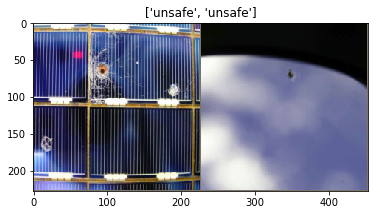

In [77]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Helpers

In [ ]:
def train(model, lossFunc, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        for phase in ['train, val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0
            num_correct = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = lossFunc(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                epoch_loss += loss.item() * inputs.size(0)
                num_correct += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / dataset_sizes[phase]
            epoch_acc = num_correct.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
    return model, optimizer

In [78]:
# downloads fully trained resnet18 model on first call
pretrained_model = models.resnet18(pretrained=True)
# reset final layer
num_features = pretrained_model.fc.in_features


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/carson/.torch/models/resnet18-5c106cde.pth
100.0%


## Network Setup

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)